In [2]:
from tensorflow import keras
import matplotlib.pyplot as plt
import os, shutil, pathlib

### 1. Obtaining the data

In [3]:
# Getting the paths of the directories of the downloaded dataset
train_dir = pathlib.Path('/Users/diegobolanos/Downloads/birds/train')
test_dir = pathlib.Path('/Users/diegobolanos/Downloads/birds/test')
validation_dir = pathlib.Path('/Users/diegobolanos/Downloads/birds/valid')

#### Extracting the classes with the highest number of images

In [4]:
# Filter the top three classes with the highest number of images
folders_images_count = {}

# Loop through the train directory and get the number of images in each folder
for bird_species in os.listdir(train_dir):
    bird_species_dir_names = os.path.join(train_dir, bird_species)
    # Check if the path is a directory
    if os.path.isdir(bird_species_dir_names):
        folder_name = os.path.basename(bird_species_dir_names)
        image_name = os.listdir(bird_species_dir_names)
        folders_images_count[folder_name] = len(image_name)

# Sort the dictionary descendingly and get the top three classes
top_species = sorted(folders_images_count.items(), key=lambda x: x[1], reverse=True)[:3]
print(top_species)

[('RUFOUS TREPE', 263), ('HOUSE FINCH', 248), ('OVENBIRD', 233)]


In [5]:
# Helper code to remove the data folder

new_base_dir = pathlib.Path("./data")

if os.path.exists(new_base_dir):
    shutil.rmtree(new_base_dir)


In [6]:
# Create the data folder for the top three classes

top_3_species_names = [class_name[0] for class_name in top_species]
new_base_dir = pathlib.Path("./data/kaggle_birds_top_3")

def make_top_3_subset(subset_name,original_dir):
    for specie_name in top_3_species_names:
        dir = new_base_dir / subset_name / specie_name
        os.makedirs(dir)
        original_images = os.listdir(original_dir / specie_name)
        for image in original_images:
            src = original_dir / specie_name / image
            dst = dir / image
            shutil.copyfile(src, dst)
        
make_top_3_subset("train",train_dir)
make_top_3_subset("test",test_dir)
make_top_3_subset("valid",validation_dir)

### Feature extraction with a pretrained model

We will use the VGG16 model, which is a model trained on the ImageNet dataset, we need to specify some parameters to have a successful feature extraction, we will use the following parameters:

weights: specifies the weight checkpoint from which to initialize the model.

include_top=False: refers to not including the "head" of the model.

In [41]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3))

In [43]:
from keras.utils import image_dataset_from_directory
from keras import layers

data_folder = pathlib.Path("./data/kaggle_birds_top_3")

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(224, 224),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "valid",
    image_size=(224, 224),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(224, 224),
    batch_size=32)

Found 744 files belonging to 3 classes.
Found 15 files belonging to 3 classes.
Found 15 files belonging to 3 classes.


### Get the training, testing and validation data from the pretrained model

In [44]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 17ms/step


In [45]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 


 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       295168    
                                                                 
 block3_conv2 (Conv2D)       (None, 56, 56, 256)       590080    
                                                                 
 block3_conv3 (Conv2D)       (None, 56, 56, 256)       590080    
                                                                 
 block3_pool (MaxPooling2D)  (None, 28, 28, 256)       0         
                                                                 
 block4_conv1 (Conv2D)       (None, 28, 28, 512)       1180160   
                                                                 
 block4_conv2 (Conv2D)       (None, 28, 28, 512)       2359808   
                                                                 
 block4_conv3 (Conv2D)       (None, 28, 28, 512)       2359808   
          

In [46]:
train_features.shape

(744, 7, 7, 512)

These are 744 images for each of the two classes, and then a 5x5 spatial matrix with a depth of 512 filters.

In [56]:
inputs = keras.Input(shape=(7, 7, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [57]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 flatten_9 (Flatten)         (None, 150528)            0         
                                                                 
 dense_17 (Dense)            (None, 256)               38535424  
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 1)                 257       
                                                                 
Total params: 38535681 (147.00 MB)
Trainable params: 38535681 (147.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Defining and training the densely connected classifier**

Here we define a new dense neural networks, of only two (neuronal/trainable) layers.

In [58]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="./models/feature_extraction",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20


ValueError: in user code:

    File "/Users/diegobolanos/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/Users/diegobolanos/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/diegobolanos/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/Users/diegobolanos/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/Users/diegobolanos/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/diegobolanos/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_7" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 7, 7, 512)


### Plotting the results

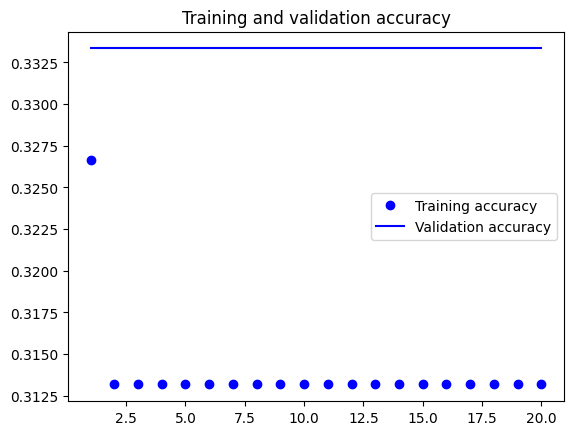

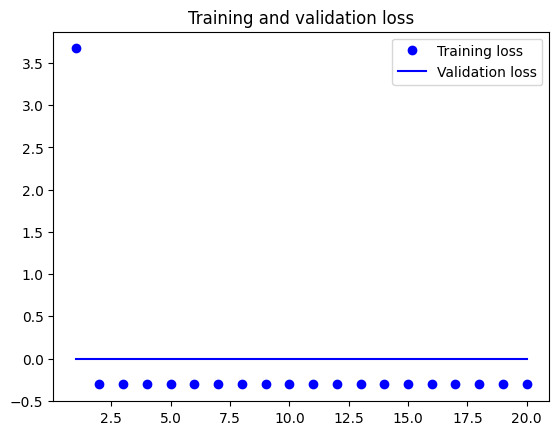

In [28]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()